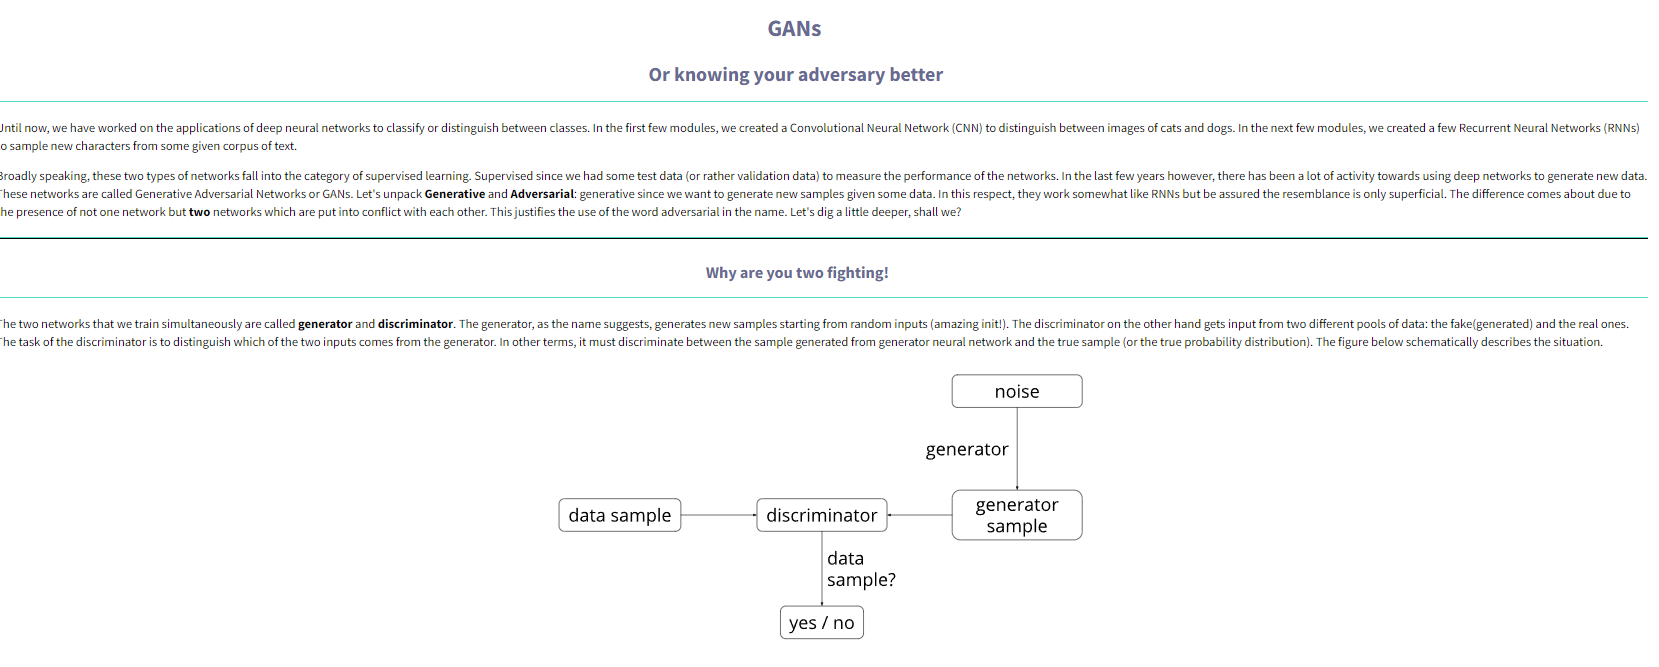

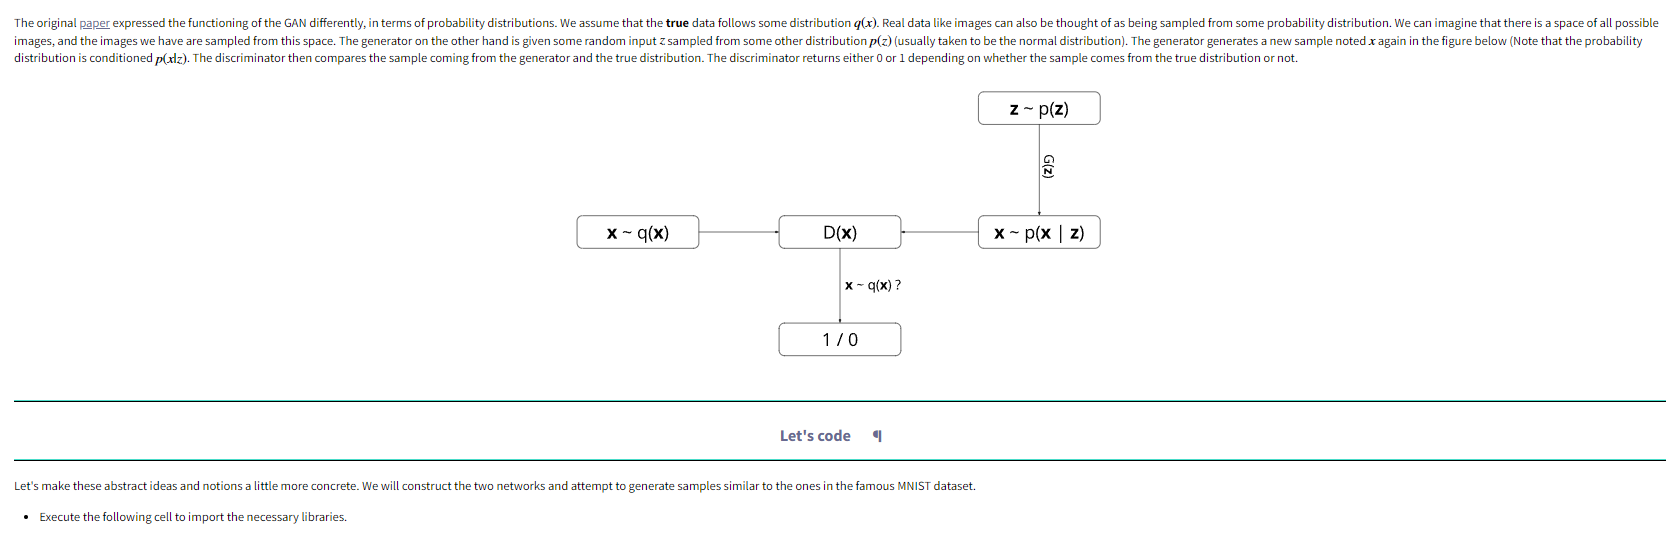

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms

import numpy as np
import os
import time
from utils_gan import show_grid

%matplotlib inline

ModuleNotFoundError: No module named 'torch'

We must now get the data and perform some preprocessing to get the images in the correct form. Fortunately, PyTorch permits us to do this in only a few lines of code. Since, some of these steps have been previously done in the module on CNNs, little help is provided.

Create a dataset object called all_data. This can be done using the MNIST function in the datasets module. The documentation will be useful. Save the data to the folder 'MNIST'. Set the parameter train to False to work on a smaller dataset first.

In [ ]:
all_data = datasets.MNIST('MNIST', train = False, download=True)

In [ ]:
"""
Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Processing...
Done!
"""

Using transforms, perform the following transformations to all_data:

Transformation to tensor

Normalize the images with mean 0.5 and standard deviation 0.5 in each channel
   You can compose the operations using transforms.Compose

In [ ]:
all_data.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

Create a DataLoader object called dataloader from all_data with batch_size=64 and with shuffling enabled.

In [ ]:
dataloader = torch.utils.data.DataLoader(all_data, batch_size=64, shuffle = True)

Let's visualize the images we do have.

Get the first batch of images using the function next after creating an iterator over dataloader. An iterator can be created using the iter function.
   This operation will return two objects: the batch of 64 images along with their labels.

Name the image tensor img_viz and the labels as labels_viz

Import the matplotlib library to visualize the images. Visualize the first few images in the batch

In [ ]:
img_viz, labels_viz = next(iter(dataloader))

import matplotlib.pyplot as plt
%matplotlib inline 

plt.imshow(img_viz[6][0])

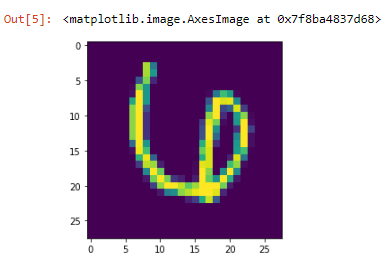

The MNIST image dataset has images of size 28x28 pixels. Thus the output of the generator network should be a vector of size 28*28.

Store the total number of pixels of the image vector in a variable called image_size.

In [ ]:
image_size = 28*28

We are now ready to create the two networks. This will be done in two steps. We will first create the generator and then the discriminator.

A skeleton of the generator network class is given below. Create a network with the following specifications:

There must be 4 preliminary blocks. Each block will be made of one linear layer and one ReLU layer.
We will begin with a first layer with sizes (100, 128)
The next blocks will increase the sizes from 128 to 1024.
The classify block will be made of a linear layer and a hyperbolic tangent non-linearity. The linear layer should downsample from 1024 to the size of the images (image_size).
Implement the forward function starting with an input img

Once written create an instance of the network and call it generator

In [ ]:
class GenNetwork(nn.Module):
    def __init__(self):
        super(GenNetwork, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(inplace = True)
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(128,256),
            nn.ReLU(inplace=True)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(256,512),
            nn.ReLU(inplace=True)
        )
        
        self.block4 = nn.Sequential(
            nn.Linear(512,1024),
            nn.ReLU(inplace=True)
        )
        
        self.classify = nn.Sequential(
            nn.Linear(1024, image_size), 
            nn.Tanh())
        
    def forward(self, img):
        img = self.block1(img)
        img = self.block2(img)
        img = self.block3(img)
        img = self.block4(img)
        img = self.classify(img)
#         img = self.model(z)
        img = img.view(img.size(0), *(1,28,28))
        return img

generator = GenNetwork()

For the discriminator, we will again use linear and ReLU layers. This time starting from the initial size, we will downsample to 512, 256, 128 and then to 1.

Since we want a number between 0 and 1, rather than using Tanh() we will use Sigmoid non-linearity.

Once the class is written, create an instance of the class and call it discriminator.

In [ ]:
class DisNetwork(nn.Module):
    def __init__(self):
        super(DisNetwork, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(inplace=True))
        
        self.block2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True))
        
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True))
        
        self.block4 = nn.Sequential(
            nn.Linear(128,1),
            nn.Sigmoid())

    def forward(self, input):
        z = input.view(input.size(0), -1)
        z = self.block1(z)
        z = self.block2(z)
        z = self.block3(z)
        z = self.block4(z)
        
        return z 

discriminator = DisNetwork()

et's declare a few more important things before we concentrate on the training.

Define a loss function gan_loss of the type Binary Cross Entropy. This is a type of cross-entropy but defined for binary outputs.

Define a learning rate lr and set it to 0.0001

Create two optimizer objects optim_gen and optim_discr. We will use the Adam optimizer for training

In [ ]:
gan_loss = torch.nn.BCELoss()
lr = 0.0001
optim_gen = torch.optim.Adam(params=generator.parameters(), lr = lr)
optim_discr = torch.optim.Adam(params=discriminator.parameters(), lr = lr)

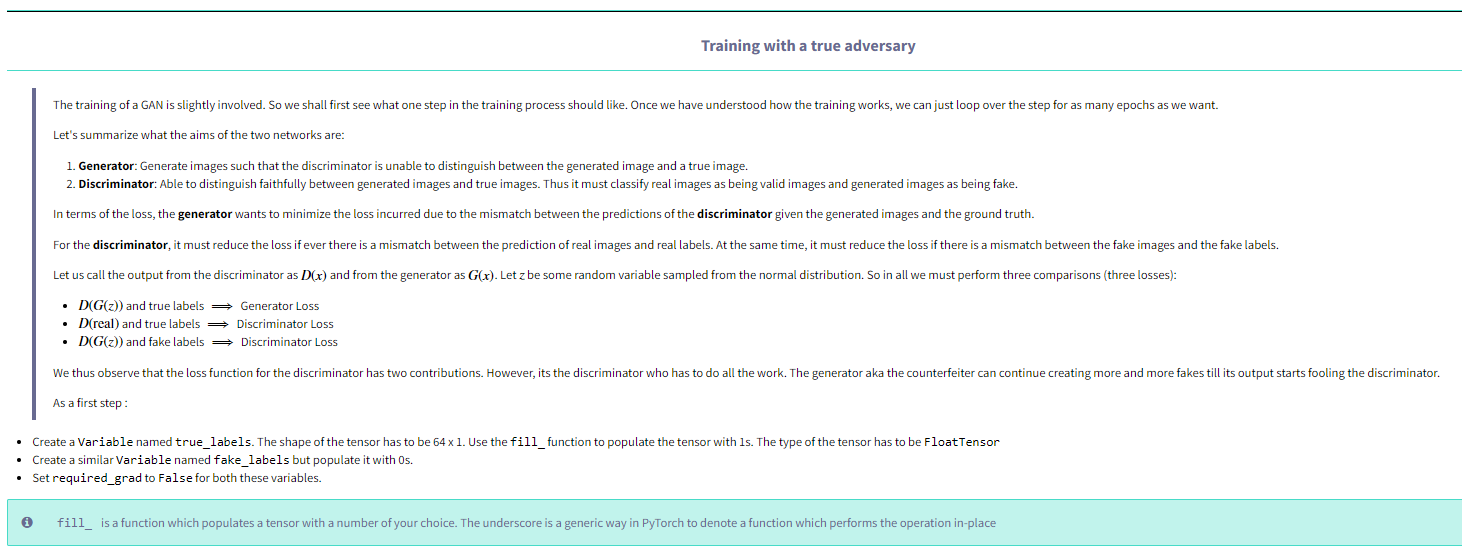

In [ ]:
true_labels = Variable(torch.FloatTensor(labels_viz.size(0),1).fill_(1.0), requires_grad = False)
fake_labels = Variable(torch.FloatTensor(labels_viz.size(0),1).fill_(0.0), requires_grad = False)

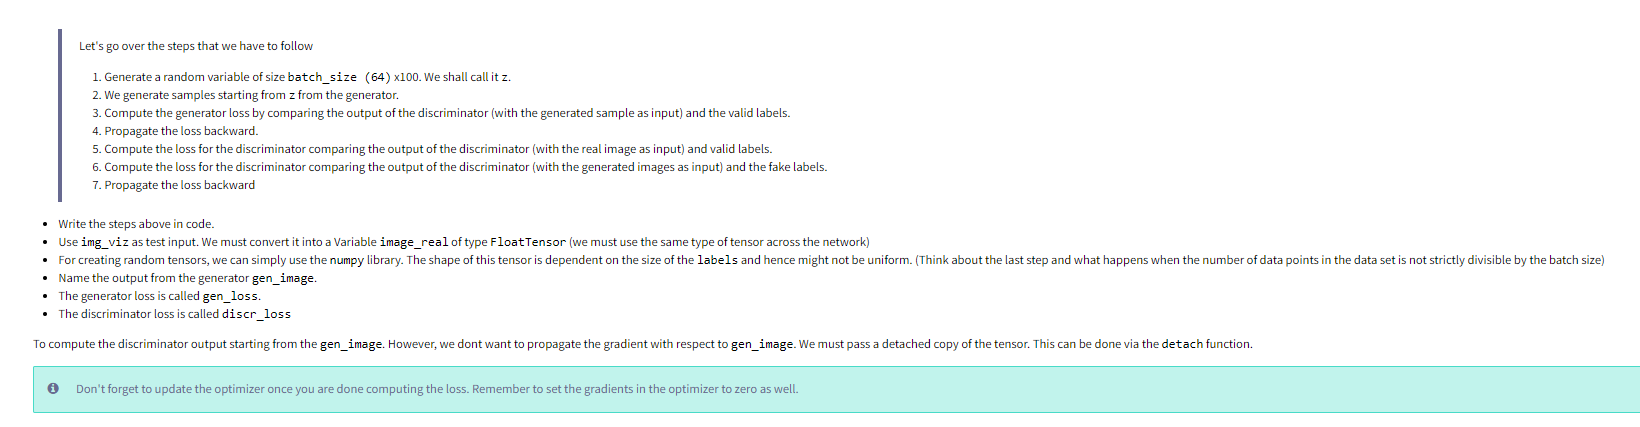

In [ ]:
image_real = Variable(img_viz)
image_real = image_real.type(torch.FloatTensor)

z = Variable(torch.FloatTensor(np.random.normal(0,1,size=(labels_viz.shape[0],100))))

optim_gen.zero_grad()
gen_image = generator(z)
gen_loss = gan_loss(discriminator(gen_image), true_labels)
gen_loss.backward()
optim_gen.step()

optim_discr.zero_grad()
discr_loss = gan_loss(discriminator(image_real), true_labels)
discr_loss += gan_loss(discriminator(gen_image.detach()), fake_labels)
discr_loss.backward()
optim_discr.step()

Bravissimo! We are all set to perform training over multiple epochs.

Set num_epochs to 10
Rewrite the steps performed above over multiple epochs and over the complete dataset. Use the enumerate function to iterate over dataloader
We have provided show_grid a little helper function which allows you to visualize a sample of the images generated from the generator after each epoch

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    pass 
    # Insert your code here 
    
    print("Epoch: {}, Discr loss: {}, Gen loss: {}".format(epoch, discr_loss.item(), gen_loss.item()))
    show_grid(gen_image[:16])
    time.sleep(1)

In [ ]:
"""
Epoch: 0, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 1, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 2, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 3, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 4, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 5, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 6, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 7, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 8, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555
Epoch: 9, Discr loss: 1.4003942012786865, Gen loss: 0.7359378933906555

 +  image ci-dessous x fois....bizarre

"""

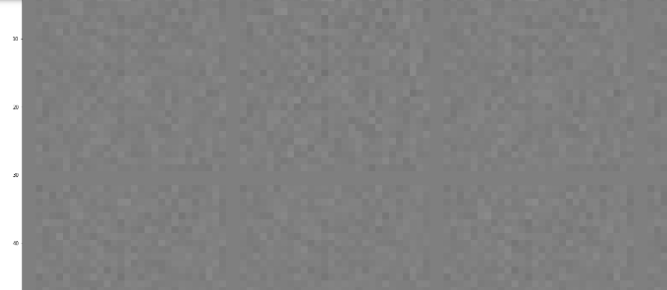

Some final comments 

Congratulate yourself! You have been able to generate new images by pitting one neural network against another. A lingering question remains though: did the generator really learn how to produce numbers? Yes and no. Looking at the images, we could think that the generator is generating images of handwritten digits. However, what the generator is learning is the style of writing the numbers. Remember that the generator had access only to the images and not the labels of those numbers.

As we have seen in earlier modules, a crucial parameter is the learning rate. In this exercise, we set the same learning rate for both networks. We could have played around with different learning rates for the two networks. There exists a systematic way of tuning the hyperparameters called hyperparameter optimization, adopted by researchers and in real-world applications. However, this is beyond the scope of this exercise.

Finally, the architecture of the generator and discriminator networks is not the same as the foundational paper by Goodfellow et al. In that paper, the discriminator used a MaxOut layer with lesser number of weights. The architecture we used here follows the spirit of the original paper. We didn't use any convolutional or GRU layers. Just as in the original paper, we used simple linear layers with a simple ReLU non-linearity. You can play around with different non-linearities to test whether the networks perform better.